In [1]:
import tensorflow as tf
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib

Using matplotlib backend: TkAgg


In [ ]:
    tf.__version__

# Data Processing for training



In [ ]:
def compute_loss(y_truth, y_pre):
    num_classes = 129
#     valid_pixels = tf.keras.backend.not_equal(y_truth, 0)
#     labels = tf.reshape(tf.boolean_mask(y_truth, valid_pixels),[-1,num_classes])
#     logits = tf.reshape(tf.boolean_mask(y_pre, valid_pixels),[-1])
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_truth, y_pre)
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_truth,logits=y_pre, name=None)
    #loss = tf.keras.backend.mean(loss)
    #loss = tf.reduce_mean(loss)      
   # print(tf.keras.backend.get_value(loss))
    return loss


In [ ]:
def disparity_threshold(gt, max_disp):
    return gt * (gt <= max_disp)
    

In [ ]:
def create_training_dataset(path, patch_size, max_disp):
    %matplotlib
    gt_path = sorted(glob.glob(path+'KITTI_dataset/2015/training/disp_noc_0/*.png'))
    left_image = sorted(glob.glob(path+'KITTI_dataset/2015/training/image_2/*.png'))
    right_image = sorted(glob.glob(path+'KITTI_dataset/2015/training/image_3/*.png'))
    gt_patches = []
    left_patches = []
    right_patches = []
    num_classes = max_disp + 1
    
    for i in range(len(gt_path)):
        print('Progress: ','{:.5}'.format( str(i / (len(gt_path)-1) * 100)),'%',end='\r')
        assert(gt_path[i].split('/')[-1] == left_image[i].split('/')[-1])
        assert(gt_path[i].split('/')[-1] == right_image[i].split('/')[-1])

        gt = cv2.imread(gt_path[i], cv2.IMREAD_GRAYSCALE)
        gt = disparity_threshold(gt, max_disp)
        left = cv2.imread(left_image[i],cv2.IMREAD_COLOR)
        left = cv2.cvtColor(left,cv2.COLOR_BGR2RGB)
        right = cv2.imread(right_image[i], cv2.IMREAD_COLOR)
        right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
       # right_padding = np.zeros((patch_size,(patch_size+max_disp ) ,3),dtype = 'uint8') #convert into same format uint8

        for b in range(int(left.shape[0]/patch_size)):
            for a in range(int(left.shape[1]/patch_size)):
                right_padding = np.zeros((patch_size,(patch_size+max_disp ) ,3),dtype = 'uint8') #convert into same format uint8
                x = a * patch_size
                y = b * patch_size

                left_patches.append(left[y:patch_size+y,x:(x+patch_size),:])
                gt_patches.append(gt[y:patch_size+y,x: (x+patch_size)])

                if (x - max_disp) < 0:
                    right_patch = right[y:patch_size+y, 0 : (x  + patch_size),:]
                    right_padding[:,(max_disp + patch_size) - right_patch.shape[1]:,:] = right_patch
                    right_patches.append(right_padding)
                else:
                    right_patch = right[y:patch_size+y, (x - max_disp)  : (x   + patch_size),:]
                    right_patches.append(right_patch)
    

    num_seg =5
    seg = int(np.array(left_patches).shape[0] / num_seg )
    print('\r')
    print('Segmentation Completed')
    for i in range(num_seg):
        print("Saving:",'{:.5}'.format((i / (num_seg-1))*100),end ='\r')
        x = i * seg
        np.save(path+'Data/training_data/left_patches_'+str(i)+'.npy', np.array(left_patches[x:x+seg]))
        np.save(path+'Data/training_data/right_patches_'+str(i)+'.npy', np.array(right_patches[x:x+seg]))
        np.save(path+'Data/training_data/gt_'+str(i)+'.npy', np.array(np.reshape(gt_patches[x:x+seg],[-1,num_classes])))
        

In [ ]:
path = '/media/sansii/Software/san_projects/Major_project/'
create_training_dataset(path, 28, 128)
    

# Creating Keras Model 

In [ ]:
def inner_product(left, right, disp, width):
    
    disp_vol = []
  
    for i in range(disp):
        output = tf.reduce_sum(tf.multiply(left, right[:,:,disp-i-1:disp -1 -i + width,: ]),axis =3)
        disp_vol.append(output)
        logits = tf.transpose(tf.stack(disp_vol),[1,2,3,0])
        logits = tf.nn.softmax(logits)
    return logits

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters = 64, kernel_size=(3,3) , strides = (1,1), padding = "same",kernel_initializer='glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3) , strides = (1,1) , padding = "same" , kernel_initializer = 'glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides =(2,2)))

model.add(keras.layers.Conv2D(filters = 64, kernel_size=(3,3) , strides = (1,1), padding = "same",kernel_initializer='glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3) , strides = (1,1) , padding = "same" , kernel_initializer = 'glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides =(2,2)))

model.add(keras.layers.Conv2D(filters = 64, kernel_size=(3,3) , strides = (1,1), padding = "same",kernel_initializer='glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3) , strides = (1,1) , padding = "same" , kernel_initializer = 'glorot_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

model.add(keras.layers.Conv2D(filters = 64, kernel_size=(3,3) , strides = (1,1), padding = "same",kernel_initializer='glorot_uniform'))
model.add(keras.layers.Conv2DTranspose(filters = 64, kernel_size = (2,2) , strides = (2,2), kernel_initializer = 'glorot_uniform'))
model.add(keras.layers.Conv2DTranspose(filters = 64, kernel_size = (2,2) , strides = (2,2), kernel_initializer = 'glorot_uniform'))


In [ ]:

max_disp = 128
W_l = 28
W_r = 28+max_disp
H = 28
num_classes = max_disp + 1
input_left =  keras.Input(shape = (H, W_l, 3))
input_right = keras.Input(shape = (H, W_r ,3))
y_truth = keras.Input(shape = (H,H))
output_left = model(input_left)
output_right= model(input_right)

outputs = inner_product(output_left, output_right, max_disp + 1, W_l)

siamese_model = keras.models.Model([input_left, input_right], outputs)
# loss = compute_loss(y_truth, outputs,num_classes = 129)
siamese_model.compile(loss=compute_loss,
                      optimizer=keras.optimizers.Adam(learning_rate=1e-6), metrics=['accuracy'])

In [ ]:
siamese_model.summary()

In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/keras_checkpoint/cp.cpkt"
logdir = "/content/drive/My Drive/Colab Notebooks/Tensorboard_logdir"


cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,verbose=1)
cp_logdir = keras.callbacks.TensorBoard(log_dir = logdir,histogram_freq = 1000)

In [ ]:
path = '/media/sansii/Software/san_projects/Major_project/'

checkpoint_path = path + "Siamese_model_checkpoint/cp.cpkt"
logdir = path+"Tensorboard_logdir"


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,verbose=1)
cp_logdir = tf.keras.callbacks.TensorBoard(log_dir = logdir,histogram_freq = 1000)

left = np.load(path+"Data/training_data/left_patches_0.npy")
right = np.load(path+"Data/training_data/right_patches_0.npy")
gt = np.load(path+"Data/training_data/gt_0.npy")

left_val = np.load(path+"Data/training_data/left_patches_4.npy")
right_val = np.load(path+"Data/training_data/right_patches_4.npy")
gt_val = np.load(path+"Data/training_data/gt_0.npy")

siamese_model.fit(x=[left, right],y =gt, batch_size=4, validation_data=([left_val,right_val] , gt_val),callbacks=[cp_callback, cp_logdir] )

In [3]:
path = '/media/sansii/Software/san_projects/Major_project/'
left = np.load(path+"Data/training_data/left_patches_0.npy")
right = np.load(path+"Data/training_data/right_patches_0.npy")
gt = np.load(path+"Data/training_data/gt_0.npy")

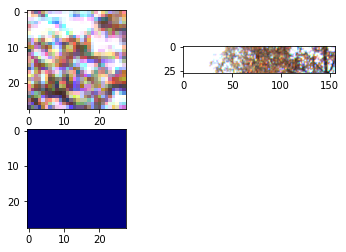

In [8]:
plt.subplot(2,2,1)
plt.imshow(left[25])
plt.subplot(2,2,2)
plt.imshow(right[25])
plt.subplot(2,2,3)
plt.imshow(gt[25],cmap='jet')

In [ ]:
path = '/media/sansii/Software/san_projects/Major_project/'
left = np.load(path+"Data/training_data/left_patches_0.npy")
right = np.load(path+"Data/training_data/right_patches_0.npy")
gt = np.load(path+"Data/training_data/gt_0.npy")

siames

In [5]:
from PIL import Image
import numpy as np
%matplotlib
path = '/media/sansii/Software/san_projects/Major_project/KITTI_dataset/training/disp_noc_0'
img = cv2.imread(path+'000023_10.png',cv2.IMREAD_GRAYSCALE)
img = np.array(img)
plt.figure(0)
plt.imshow(img, cmap ='jet')
plt.show()
print(img.shape)

Using matplotlib backend: TkAgg


TypeError: Image data cannot be converted to float

In [ ]:
a = np.array([[[1,3,4]]])
print(a.shape)

In [ ]:
path = '/media/sansii/Software/san_projects/Major_project/KITTI_dataset/2015/training/disp_noc_0/'
img = cv2.imread(path+'000023_10.png',cv2.IMREAD_GRAYSCALE)
right_padding = np.zeros_like(np.array(img))

In [ ]:
right_padding = np.zeros((28,128 ,3))


In [ ]:
def load_groudtruth_data(path):
    gt_path = sorted(glob.glob(path+'KITTI_dataset/2015/training/disp_noc_0/*.png'))
    for i in range(len(gt_path)):
        gt = np.array(cv2.imread(gt_path[i], cv2.IMREAD_GRAYSCALE))
        if gt.max() > 128:
            print("                    ",end = '\r')
            gt = disparity_threshold(gt, 128)
            print("Max:", gt.max(),end = '\r')
            cv2.imshow('gt',gt)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
            
        

In [6]:
path = '/media/sansii/Software/san_projects/Major_project/'


NameError: name 'load_groudtruth_data' is not defined

In [ ]:
%matplotlib
a = 47
plt.subplot(2,2,1)
plt.imshow(left[a])
plt.subplot(2,2,2)

plt.imshow(right[a])
plt.subplot(2,2,3)
plt.imshow(gt[a],cmap = 'jet')
plt.subplot(2,2,4)
plt.show()
print(left.shape)

In [18]:
deck = list(range(0, 200))
np.random.shuffle(deck)

In [20]:
print(deck[0:40])

[53, 194, 54, 11, 147, 3, 159, 88, 36, 102, 164, 22, 105, 25, 49, 15, 60, 89, 98, 82, 68, 103, 21, 113, 190, 123, 19, 186, 119, 106, 127, 193, 14, 57, 146, 93, 157, 6, 46, 61]


In [38]:
a = np.array([[0 ,1 ,2, 2, 2],[1, 5,6,7,8],[2,3,4,6,77],[3,22,33,44,55],[0,6,7,8,9],[4,22,11,33,55],[0,5,4,33,2]])
valid_choices=np.where(a!=0)
valid_choise = list(map(list,zip(*valid_choices)))
for x_y_pair in valid_choise:
    print(x_y_pair[0])


0
0
0
0
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
5
5
5
5
5
6
6
6
6


In [17]:
path = '/media/sansii/Software/san_projects/Major_project/KITTI_dataset/2015/training/disp_noc_0/'

img = cv2.imread(path+'000023_10.png',cv2.IMREAD_GRAYSCALE)

In [12]:
plt.imshow(img,cmap = 'jet')

In [18]:
#Smoothing
def disparity(left_matcher):
    
    right_matcher = cv2.ximgproc.createRightMatcher(matcher_left= left_matcher)

    # FILTER Parameters
    lmbda = 80000
    sigma = 1.2
    visual_multiplier = 1.0

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = left_matcher.compute(cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)).astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL).astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY), None, dispr)  # important to put "imgL" here!!!
    #filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    #filteredImg = np.uint8(filteredImg)
   
    return filteredImg

In [19]:
filtered_img = disparity(img)

TypeError: Expected Ptr<cv::StereoMatcher> for argument 'matcher_left'